# Ellipse Properties

Some useful ellipse properties.

# Code

In [10]:
%matplotlib inline

In [11]:
import math
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt


class Ellipse:

    def __init__(self, a, b, phi, x, y):
        """Simple ellispe type
        
        Parameters
        ----------
        a, b : float, float
            Major/minor axis lengths.
        phi : float
            Rotation angle measured from ???.
        x, y : float, float
            Center coordinates.
        """
        
        self.a = a
        self.b = b
        self.phi = phi
        self.x = x
        self.y = y

    def point(self, t):
        """Evaluate point on the ellipse at a give t value
        
        Parameters
        ----------
        t : float
            Value around ellipse, measure from 0 to 2Π
        """
        
        x = self.a * math.cos(self.phi) * math.cos(t) - \
            self.b * math.sin(self.phi) * math.sin(t) + self.x
        y = self.a * math.sin(self.phi) * math.cos(t) + \
            self.b * math.cos(self.phi) * math.sin(t) + self.y
        return x, y

    def slope(self, t):
        """Evaluate slope vector at a given t value
        
        Parameters
        ----------
        t : float
            Value around ellipse, measure from 0 to 2Π
        """
        
        x = self.a * math.cos(self.phi) * math.sin(t) + \
            self.b * math.sin(self.phi) * math.cos(t)
        y = self.a * math.sin(self.phi) * math.sin(t) - \
            self.b * math.cos(self.phi) * math.cos(t)
        return x, y

    def curvature(self, t):
        """ Evaluate curvature on the ellipse at a given t value
        
        Parameters
        ----------
        t : float
            Value around ellipse, measure from 0 to 2Π
        """
        
        k = (self.a*self.b) / ((self.a)**2.0 * (math.sin(t))**2.0 + \
                               (self.b)**2.0 * (math.cos(t))**2.0)**(1.5)
        return k

    def nearest_point(self, x, y):
        """ Estimate nearest point on ellipse to given coordinates
        
        Parameters
        ----------
        x, y : float, float
            Coordinates to evaluate
        """
        
        a, b = self.a, self.b
        
        # Rotate the point into csys where ellipse is
        #   centered at 0 and a,b are along x, y axes

        rx = (y - self.y) * math.sin(self.phi) + \
             (x - self.x) * math.cos(self.phi)
        ry = (y - self.y) * math.cos(self.phi) - \
             (x - self.x) * math.sin(self.phi)

        if rx == 0 and ry == 0:
            # Degenerate point in dead center of ellipse
            #   Just return point at minor axis
            return self.point(0)

        # Polynomial coefficients in terms of t (t^4, t^3, etc...)
        ps = [1,
              -2 * (a*a + b*b),
              a**4 + b**4 + 4 * a*a * b*b - b*b * ry*ry - a*a * rx*rx,
              -2 * a*a * b*b *(a*a + b*b - rx*rx - ry*ry),
              a*a * b*b * (a*a * b*b - b*b * rx*rx - a*a * ry*ry)]

        # Solve roots and take minimum real root (nearest point)
        roots = np.roots(ps)
        real_roots = [root for root in roots if np.imag(root) == 0.0]
        t = np.real(min(real_roots))

        # Point in rotated space
        er_x = a ** 2 * rx / (a ** 2 - t)
        er_y = b ** 2 * ry / (b ** 2 - t)

        # Rotate point back into original space
        xsr = er_x * math.cos(self.phi) - \
              er_y * math.sin(self.phi) + self.x
        ysr = er_x * math.sin(self.phi) + \
              er_y * math.cos(self.phi) + self.y

        return xsr, ysr

# Test Ellipse

In [12]:
e = Ellipse(1, 4, 0.34 * np.pi, 2, 4)
t_vals = np.linspace(0.0, 2*np.pi, 100)

# Point & Slope

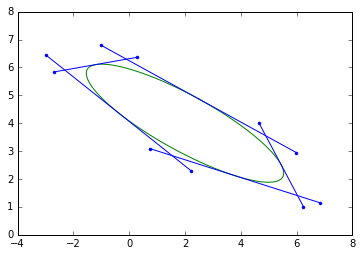

In [13]:
points = [e.point(t) for t in t_vals]
plt.plot([p[0] for p in points], [p[1] for p in points], 'g')

# Slope at point
for t in t_vals[::20]:
    x, y = e.point(t)
    vx, vy = e.slope(t)
    x0, y0 = x + vx, y + vy
    x1, y1 = x - vx, y - vy
    plt.plot([x0, x1], [y0, y1], 'b.-')

plt.axes().set_aspect('equal', 'datalim')
plt.show()

# Curvature

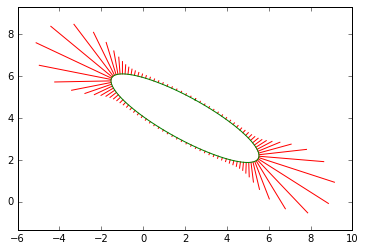

In [14]:
cs = [e.curvature(t) for t in t_vals]
vs = [np.array(e.slope(t)) / la.norm(np.array(e.slope(t))) for t in t_vals]
rs = [c * v for c, v in zip(cs, vs)]

for point, rs in zip(points, rs):
    plt.plot([point[0], point[0] - rs[1]], [point[1], point[1] + rs[0]], 'r')

plt.plot([p[0] for p in points], [p[1] for p in points], 'g')
plt.axes().set_aspect('equal', 'datalim')
plt.show()

# Nearest Neighbor

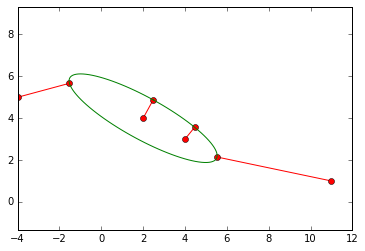

In [15]:
rx, ry = 11, 1
nx, ny = e.nearest_point(rx, ry)
plt.plot([rx, nx], [ry, ny], 'ro-')

rx, ry = 4, 3
nx, ny = e.nearest_point(rx, ry)
plt.plot([rx, nx], [ry, ny], 'ro-')

rx, ry = -4, 5
nx, ny = e.nearest_point(rx, ry)
plt.plot([rx, nx], [ry, ny], 'ro-')

# Center point has 2 answers, t=0 value default (mninor axis side)
rx, ry = 2, 4
nx, ny = e.nearest_point(rx, ry)
plt.plot([rx, nx], [ry, ny], 'ro-')

plt.plot([p[0] for p in points], [p[1] for p in points], 'g')
plt.axes().set_aspect('equal', 'datalim')
plt.show()

In [16]:
def fit_ellipse(points):
    np_points = np.array(points)
    xs = np_points[:,0]
    ys = np_points[:,1]

    # Shift points about zero
    mxs = xs-xs.mean()
    mys = ys-ys.mean()

    D = np.transpose([mxs**2, mxs*mys, mys**2, mxs, mys, np.ones(len(xs))])

    S = np.dot(D.T, D)
    C = np.zeros([6,6])

    C[0,2] = 2
    C[2,0] = 2
    C[1,1] = -1

    E, V =  la.eig(np.dot(la.inv(S), C))
    n = np.argmax(np.abs(E))
    res = V[:,n]

    A = res[0]
    B = res[1] * 0.5
    C = res[2]
    D = res[3] * 0.5
    F = res[4] * 0.5
    G = res[5]
    
    # Use discriminant to verify its an ellipse
    disc = B**2.0 - 4.0*A*C
    
    if disc >= 0:
        print("error, conic is not an ellipse!")

    # Calculate center point
    num = B**2 - A*C
    x0 = (C*D - B*F)/num + xs.mean()
    y0 = (A*F - B*D)/num + ys.mean()

    # Calculate angle
    phi = 0.5 * np.arctan(2*B / (A-C))

    # Calculate focus points
    num = 2*(A*F**2 + C*D**2 + G*B**2 - 2*B*D*F - A*C*G)
    den1 = (B*B - A*C) * ((C-A) * np.sqrt(1 + 4*B*B / ((A-C) * (A-C))) - (C+A))
    den2 = (B*B - A*C) * ((A-C) * np.sqrt(1 + 4*B*B / ((A-C) * (A-C))) - (C+A))

    a = np.sqrt(num / den1)
    b = np.sqrt(num / den2)

    # Force 'a' to be major axis 
    if a < b:
        a, b = b, a
    
        if phi < 0:
            phi += 0.5 * math.pi

        else:
            phi -= 0.5 * math.pi

    return Ellipse(a=a, b=b, x=x0, y=y0, phi=phi)

# Regression Fit

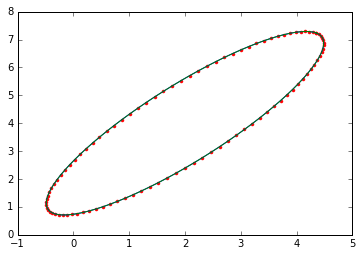

          orig   fitted
    a    4.000    4.000
    b    1.000    1.000
  phi    0.942    0.942
    x    2.000    2.000
    y    4.000    4.000


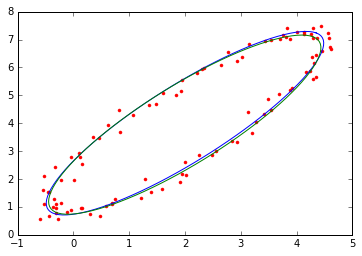

          orig   fitted
    a    4.000    3.900
    b    1.000    1.029
  phi    0.942    0.942
    x    2.000    1.996
    y    4.000    3.947


In [17]:
# Make an ellipse
e = Ellipse(a=4, b=1, phi=0.3*np.pi, x=2, y=4)

# Sample from it and add some noise
t_vals = np.linspace(0.0, 2 * np.pi, 100)
pnts = [e.point(t) for t in t_vals]
noise_pnts = np.array(pnts) + 0.0001*(np.random.rand(100, 2)-0.5)

# Fit a new ellipse to the noisey points
e0 = fit_ellipse(noise_pnts)
pnts0 = [e0.point(t) for t in t_vals]

# Plot comparison
plt.plot([p[0] for p in noise_pnts], [p[1] for p in noise_pnts], 'r.')
plt.plot([p[0] for p in pnts], [p[1] for p in pnts], 'b-')
plt.plot([p[0] for p in pnts0], [p[1] for p in pnts0], 'g-')
plt.show()

print("{0:>5} {1:>8} {2:>8}".format(' ', 'orig', 'fitted'))
print("{0:>5} {1:>8.3f} {2:>8.3f}".format('a', e.a, e0.a))
print("{0:>5} {1:>8.3f} {2:>8.3f}".format('b', e.b, e0.b))
print("{0:>5} {1:>8.3f} {2:>8.3f}".format('phi', e.phi, e0.phi))
print("{0:>5} {1:>8.3f} {2:>8.3f}".format('x', e.x, e0.x))
print("{0:>5} {1:>8.3f} {2:>8.3f}".format('y', e.y, e0.y))

# Sample from ellipse and add some bigger noise
noise_pnts = np.array([e.point(t) for t in t_vals]) + \
             0.5000*(np.random.rand(100, 2)-0.5)

# Fit a new ellipse to the noisey points
e1 = fit_ellipse(noise_pnts)
pnts1 = [e1.point(t) for t in t_vals]

# Plot comparison
plt.plot([p[0] for p in noise_pnts], [p[1] for p in noise_pnts], 'r.')
plt.plot([p[0] for p in pnts], [p[1] for p in pnts], 'b-')
plt.plot([p[0] for p in pnts1], [p[1] for p in pnts1], 'g-')
plt.show()

print("{0:>5} {1:>8} {2:>8}".format(' ', 'orig', 'fitted'))
print("{0:>5} {1:>8.3f} {2:>8.3f}".format('a', e.a, e1.a))
print("{0:>5} {1:>8.3f} {2:>8.3f}".format('b', e.b, e1.b))
print("{0:>5} {1:>8.3f} {2:>8.3f}".format('phi', e.phi, e1.phi))
print("{0:>5} {1:>8.3f} {2:>8.3f}".format('x', e.x, e1.x))
print("{0:>5} {1:>8.3f} {2:>8.3f}".format('y', e.y, e1.y))